In [77]:
#importing libraries
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import seaborn as sns
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.column import encode_categorical
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM
import scipy as sp
import seaborn as sns
import pymc3 as pm
import arviz as az
from matplotlib.ticker import StrMethodFormatter
from theano import shared
from theano import tensor as tt
sns.set_style("whitegrid")

In [78]:
#setting seed
np.random.seed(31415)
random_state = 20

In [79]:
#Reading data
data = pd.read_table('../../data/brca_metabric_clinical_data.tsv')
data.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,...,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,...,YES,138.65,0:Not Recurred,1,Primary,Female,ER-/HER2-,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,...,YES,83.52,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,...,NO,151.28,1:Recurred,1,Primary,Female,NaN,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,...,YES,162.76,0:Not Recurred,1,Primary,Female,NaN,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,...,YES,18.55,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [80]:
data_filtered_1 = data[data['Overall Survival (Months)'].notna()]
data_filtered_2 = data_filtered_1[data_filtered_1['Overall Survival Status'].notna()]
data_filtered_2 = data_filtered_2[data_filtered_2['Overall Survival (Months)'] > 0]

In [81]:
data_filtered_2.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed',
       'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort',
       'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Number of Samples Per Patient', 'Sample Type', 'Sex',
       '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage',
       'Patient's Vital Status'],
      dtype='object')

In [82]:
numerical_features = ['Age at Diagnosis', 'Neoplasm Histologic Grade', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Tumor Size']
categorical_features = ['Cellularity', 'Chemotherapy', 'HER2 Status', 'Inferred Menopausal State', 'Primary Tumor Laterality', 'Tumor Stage']
columns = numerical_features+categorical_features
label_columns = ['Overall Survival Status', 'Overall Survival (Months)']
print(len(numerical_features))
print(len(categorical_features))
print(len(columns))
print(len(label_columns))

6
6
12
2


In [83]:
#Preprocessing
X = data_filtered_2[columns]
Y = data_filtered_2[label_columns]
# data = data.fillna(data.mean()).fillna(data.mode().iloc[0])

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=random_state)

In [85]:
def impute(X, column_type):
    if(column_type == 'numerical'):
        imputer = SimpleImputer(strategy = 'mean')
    else:
        imputer = SimpleImputer(strategy = 'most_frequent')
    imputer.fit(X)
    Xtrans = pd.DataFrame(imputer.transform(X), columns = X.columns)
    return Xtrans, imputer

def min_max_scaling(X):
    scaler = MinMaxScaler()
    scaler.fit(X)
    df_norm = pd.DataFrame(scaler.transform(X), columns = X.columns)
    return df_norm, scaler    

In [86]:
#Imputing columns
X_numerical, numerical_imputer = impute(X_train[numerical_features], "numerical")
X_categorical, categorical_imputer = impute(X_train[categorical_features], "categorical")
# for column in categorical_features:
#     X_numerical[column] = X_categorical[column]

In [87]:
#Standardizing columns and One hot encoding
X_numerical_std, numerical_scaler = min_max_scaling(X_numerical)
X_categorical_ohe = pd.get_dummies(X_categorical)
X_final = X_numerical_std.join(X_categorical_ohe)
X_final.head()
# X_final.isnull().values.any()

,Age at Diagnosis,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Tumor Size,Cellularity_High,Cellularity_Low,Cellularity_Moderate,Chemotherapy_NO,...,HER2 Status_Positive,Inferred Menopausal State_Post,Inferred Menopausal State_Pre,Primary Tumor Laterality_Left,Primary Tumor Laterality_Right,Tumor Stage_0.0,Tumor Stage_1.0,Tumor Stage_2.0,Tumor Stage_3.0,Tumor Stage_4.0
0,0.372881,0.5,0.022222,0.075949,0.567164,0.104972,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
1,0.346817,0.5,0.000000,0.164557,0.378731,0.077348,0,0,1,1,...,0,0,1,1,0,0,0,1,0,0
2,0.696624,1.0,0.022222,0.101266,0.763060,0.243094,0,0,1,1,...,0,1,0,1,0,0,0,1,0,0
3,0.550776,1.0,0.000000,0.063291,0.576866,0.248619,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
4,0.662869,1.0,0.244444,0.012658,0.949627,0.243094,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0


In [88]:
unique, counts = np.unique(y_train['Overall Survival Status'].to_numpy(), return_counts = True)
print(unique)

['0:LIVING' '1:DECEASED']


In [89]:
X_numerical_std.head()

,Age at Diagnosis,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Tumor Size
0,0.372881,0.5,0.022222,0.075949,0.567164,0.104972
1,0.346817,0.5,0.000000,0.164557,0.378731,0.077348
2,0.696624,1.0,0.022222,0.101266,0.763060,0.243094
3,0.550776,1.0,0.000000,0.063291,0.576866,0.248619
4,0.662869,1.0,0.244444,0.012658,0.949627,0.243094


In [90]:
# y_train['Overall Survival Status'] = y_train['Overall Survival Status'].astype(bool)
d = {'0:LIVING': False, '1:DECEASED': True}
y_train['Overall Survival Status'] = y_train['Overall Survival Status'].map(d)
unique, counts = np.unique(y_train['Overall Survival Status'].to_numpy(), return_counts = True)
y = y_train.to_numpy()
y = np.core.records.fromarrays(y.transpose(), names = 'Overall Survival Status, Overall Survival (Months)', formats = 'b1, f8')
y_log_t = y.copy()
y_log_t['Overall Survival (Months)'] = np.log1p(y['Overall Survival (Months)'])
X_final = X_final.to_numpy()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
# y_train.head()

In [92]:
ref_estimator = FastSurvivalSVM(rank_ratio=0.0, max_iter=1000, tol=1e-5, random_state=0)
ref_estimator.fit(X_final, y_log_t)

cindex = concordance_index_censored(
    y['Overall Survival Status'],
    y['Overall Survival (Months)'],
    -ref_estimator.predict(X_final),  # flip sign to obtain risk scores
)
print(round(cindex[0], 3))

0.68


In [93]:
X_test_numerical = X_test[numerical_features]
X_test_categorical = X_test[categorical_features]
X_test_numerical_ = numerical_imputer.transform(X_test_numerical)
X_test_categorical_ = categorical_imputer.transform(X_test_categorical)
X_test_numerical_std = pd.DataFrame(numerical_scaler.transform(X_test_numerical_), columns = X_test_numerical.columns)
X_test_categorical_ohe = pd.get_dummies(pd.DataFrame(X_test_categorical_, columns = X_test_categorical.columns))
X_test_final = X_test_numerical_std.join(X_test_categorical_ohe)
X_test_final.head()

,Age at Diagnosis,Neoplasm Histologic Grade,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Tumor Size,Cellularity_High,Cellularity_Low,Cellularity_Moderate,Chemotherapy_NO,...,HER2 Status_Positive,Inferred Menopausal State_Post,Inferred Menopausal State_Pre,Primary Tumor Laterality_Left,Primary Tumor Laterality_Right,Tumor Stage_0.0,Tumor Stage_1.0,Tumor Stage_2.0,Tumor Stage_3.0,Tumor Stage_4.0
0,0.510184,0.000000,0.000000,0.050633,0.196269,0.138122,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
1,0.549067,0.500000,0.000000,0.063291,0.378358,0.071823,0,0,1,1,...,0,1,0,1,0,0,1,0,0,0
2,0.758439,1.000000,0.466667,0.012658,0.943284,0.149171,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0.529697,0.711881,0.000000,0.088608,0.009328,0.132597,0,0,1,1,...,0,1,0,1,0,0,0,1,0,0
4,0.309785,0.500000,0.000000,0.037975,0.382463,0.132597,0,0,1,1,...,0,0,1,0,1,0,1,0,0,0


In [94]:
y_test['Overall Survival Status'] = y_test['Overall Survival Status'].map(d)
y = y_test.to_numpy()
y = np.core.records.fromarrays(y.transpose(), names = 'Overall Survival Status, Overall Survival (Months)', formats = 'b1, f8')
y_log_t = y.copy()
y_log_t['Overall Survival (Months)'] = np.log1p(y['Overall Survival (Months)'])
X_test_final = X_test_final.to_numpy()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [95]:
cindex = concordance_index_censored(
    y['Overall Survival Status'],
    y['Overall Survival (Months)'],
    -ref_estimator.predict(X_test_final),  # flip sign to obtain risk scores
)
print(round(cindex[0], 3))

0.673


In [96]:
predict_fn = lambda x: ref_estimator.predict(x)

In [97]:
def numerical_sampling(data, features, samples, mu, sigma):
    sampled_data = pd.DataFrame()
    for column in features:
        sampled_data[column] = np.random.normal(0, 1, samples)
        sampled_data[column] = sampled_data[column]*mu[column]+sigma[column]
    return sampled_data

In [98]:
def categorical_sampling(data, features, samples, values, proba):
    sampled_data = pd.DataFrame()
    for column in features:
        sampled_data[column] = np.random.choice(values[column], size = samples, replace = True, p = proba[column])
    return sampled_data

In [125]:
def gumbel_sf(y, μ, σ):
    return 1.0 - tt.exp(-tt.exp(-(y - μ) / σ))

In [135]:
def explanation(predict_fn, data, sample, y, y_sample, samples, status_columns, numerical_features, categorical_features, sampling_type = "specific"):
#     print(y_sample['Overall Survival Status'])
    unique, counts = np.unique(y[status_columns[0]].to_numpy(), return_counts = True)
    y_samples = categorical_sampling(y[status_columns[0]], [status_columns[0]], samples, {status_columns[0] : unique}, {status_columns[0] : counts/np.sum(counts)})
    data_categorical = sample[categorical_features]
    data_numerical = sample[numerical_features]
    if sampling_type == "random":
        mu = data[numerical_features].mean()
        sigma = data[numerical_features].std()
        numerical_samples = numerical_sampling(data_numerical, numerical_features, samples, mu, sigma)
    elif sampling_type == "specific":
        sigma = {}
        mu = {}
        for column in numerical_features:
            sigma[column] = 1
            mu[column] = data_numerical[column]
        numerical_samples = numerical_sampling(data_numerical, numerical_features, samples, mu, sigma)
    values = {}
    proba = {}
    for column in categorical_features:
        unique, counts = np.unique(data[column].to_numpy(), return_counts = True)
        values[column] = unique
        proba[column] = counts/np.sum(counts)
    categorical_samples = categorical_sampling(data_categorical, categorical_features, samples, values, proba)
    numerical_samples_std, _ = min_max_scaling(numerical_samples)
    categorical_samples_ohe = pd.get_dummies(categorical_samples)
    final_samples = numerical_samples_std.join(categorical_samples_ohe)
    y_samples[status_columns[1]] = np.expm1(predict_fn(final_samples))
    X = np.empty((samples, 1+final_samples.shape[1]))
    columns = final_samples.columns
    X[:, 0] = 1.0
    for i in range(len(columns)):
        X[:, i+1] = final_samples[columns[i]]
    with pm.Model() as weibull_model:
        beta = pm.Normal("beta", 0.0, 5, shape = len(columns)+1)
    X_ = shared(X)
    with weibull_model:
        eta = beta.dot(X_.T)
    with weibull_model:
        s = pm.HalfNormal("s", 5.0)
    y_ = y_samples[status_columns[1]]
    y_std = (y_-y_.mean())/y_.std()
    cens = np.array(y_samples[status_columns[0]] == True)
    cens_ = shared(cens)
    with weibull_model:
        y_obs = pm.Gumbel("y_obs", eta[~cens_], s, observed = y_std[~cens])
    with weibull_model:
        y_cens = pm.Potential("y_cens", gumbel_sf(np.array(y_std[cens]), eta[cens_], s))
    SEED = 845199  # from random.org, for reproducibility
    SAMPLE_KWARGS = {"chains": 3, "tune": 1000, "random_seed": [SEED, SEED + 1, SEED + 2]}
    with weibull_model:
        weibull_trace = pm.sample(**SAMPLE_KWARGS)
    return weibull_trace
#     pm.energyplot(weibull_trace)
#     pm.bfmi(weibull_trace)
#     max(np.max(gr_stats) for gr_stats in pm.rhat(weibull_trace).values())

In [136]:
X_test_expl = X_test_numerical_std.join(pd.DataFrame(X_test_categorical_, columns = X_test_categorical.columns))
X_train_expl = X_numerical_std.join(X_categorical)
# print(y_train.head())
index = 0
trace = explanation(predict_fn = predict_fn, data = X_train_expl, sample = X_test_expl.iloc[index, :], y = y_train, y_sample = y_test.iloc[index, :], samples = 5000, 
            status_columns = ['Overall Survival Status', 'Overall Survival (Months)'], numerical_features = numerical_features, 
            categorical_features = categorical_features, sampling_type = "random")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [s, beta]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 1875 seconds.
There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 852 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.549188919954415, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [26]:
# import scipy as sp
# import seaborn as sns
# import pymc3 as pm
# import arviz as az
# from matplotlib.ticker import StrMethodFormatter
# from theano import shared
# from theano import tensor as tt

In [30]:
# with pm.Model() as weibull_method:
#     beta = pm.Normal("beta", 0.0, 5, shape = 2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:>

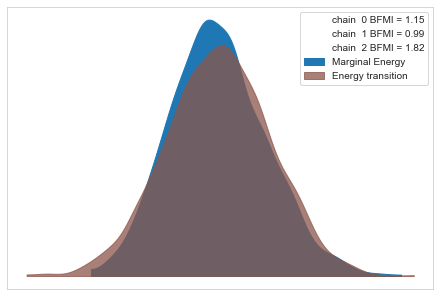

In [137]:
pm.energyplot(trace)

In [138]:
pm.bfmi(trace)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([1.1461726 , 0.99284662, 1.81639366])

In [139]:
max(np.max(gr_stats) for gr_stats in pm.rhat(trace).values())

<xarray.DataArray 'beta' ()>
array(1.92356731)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


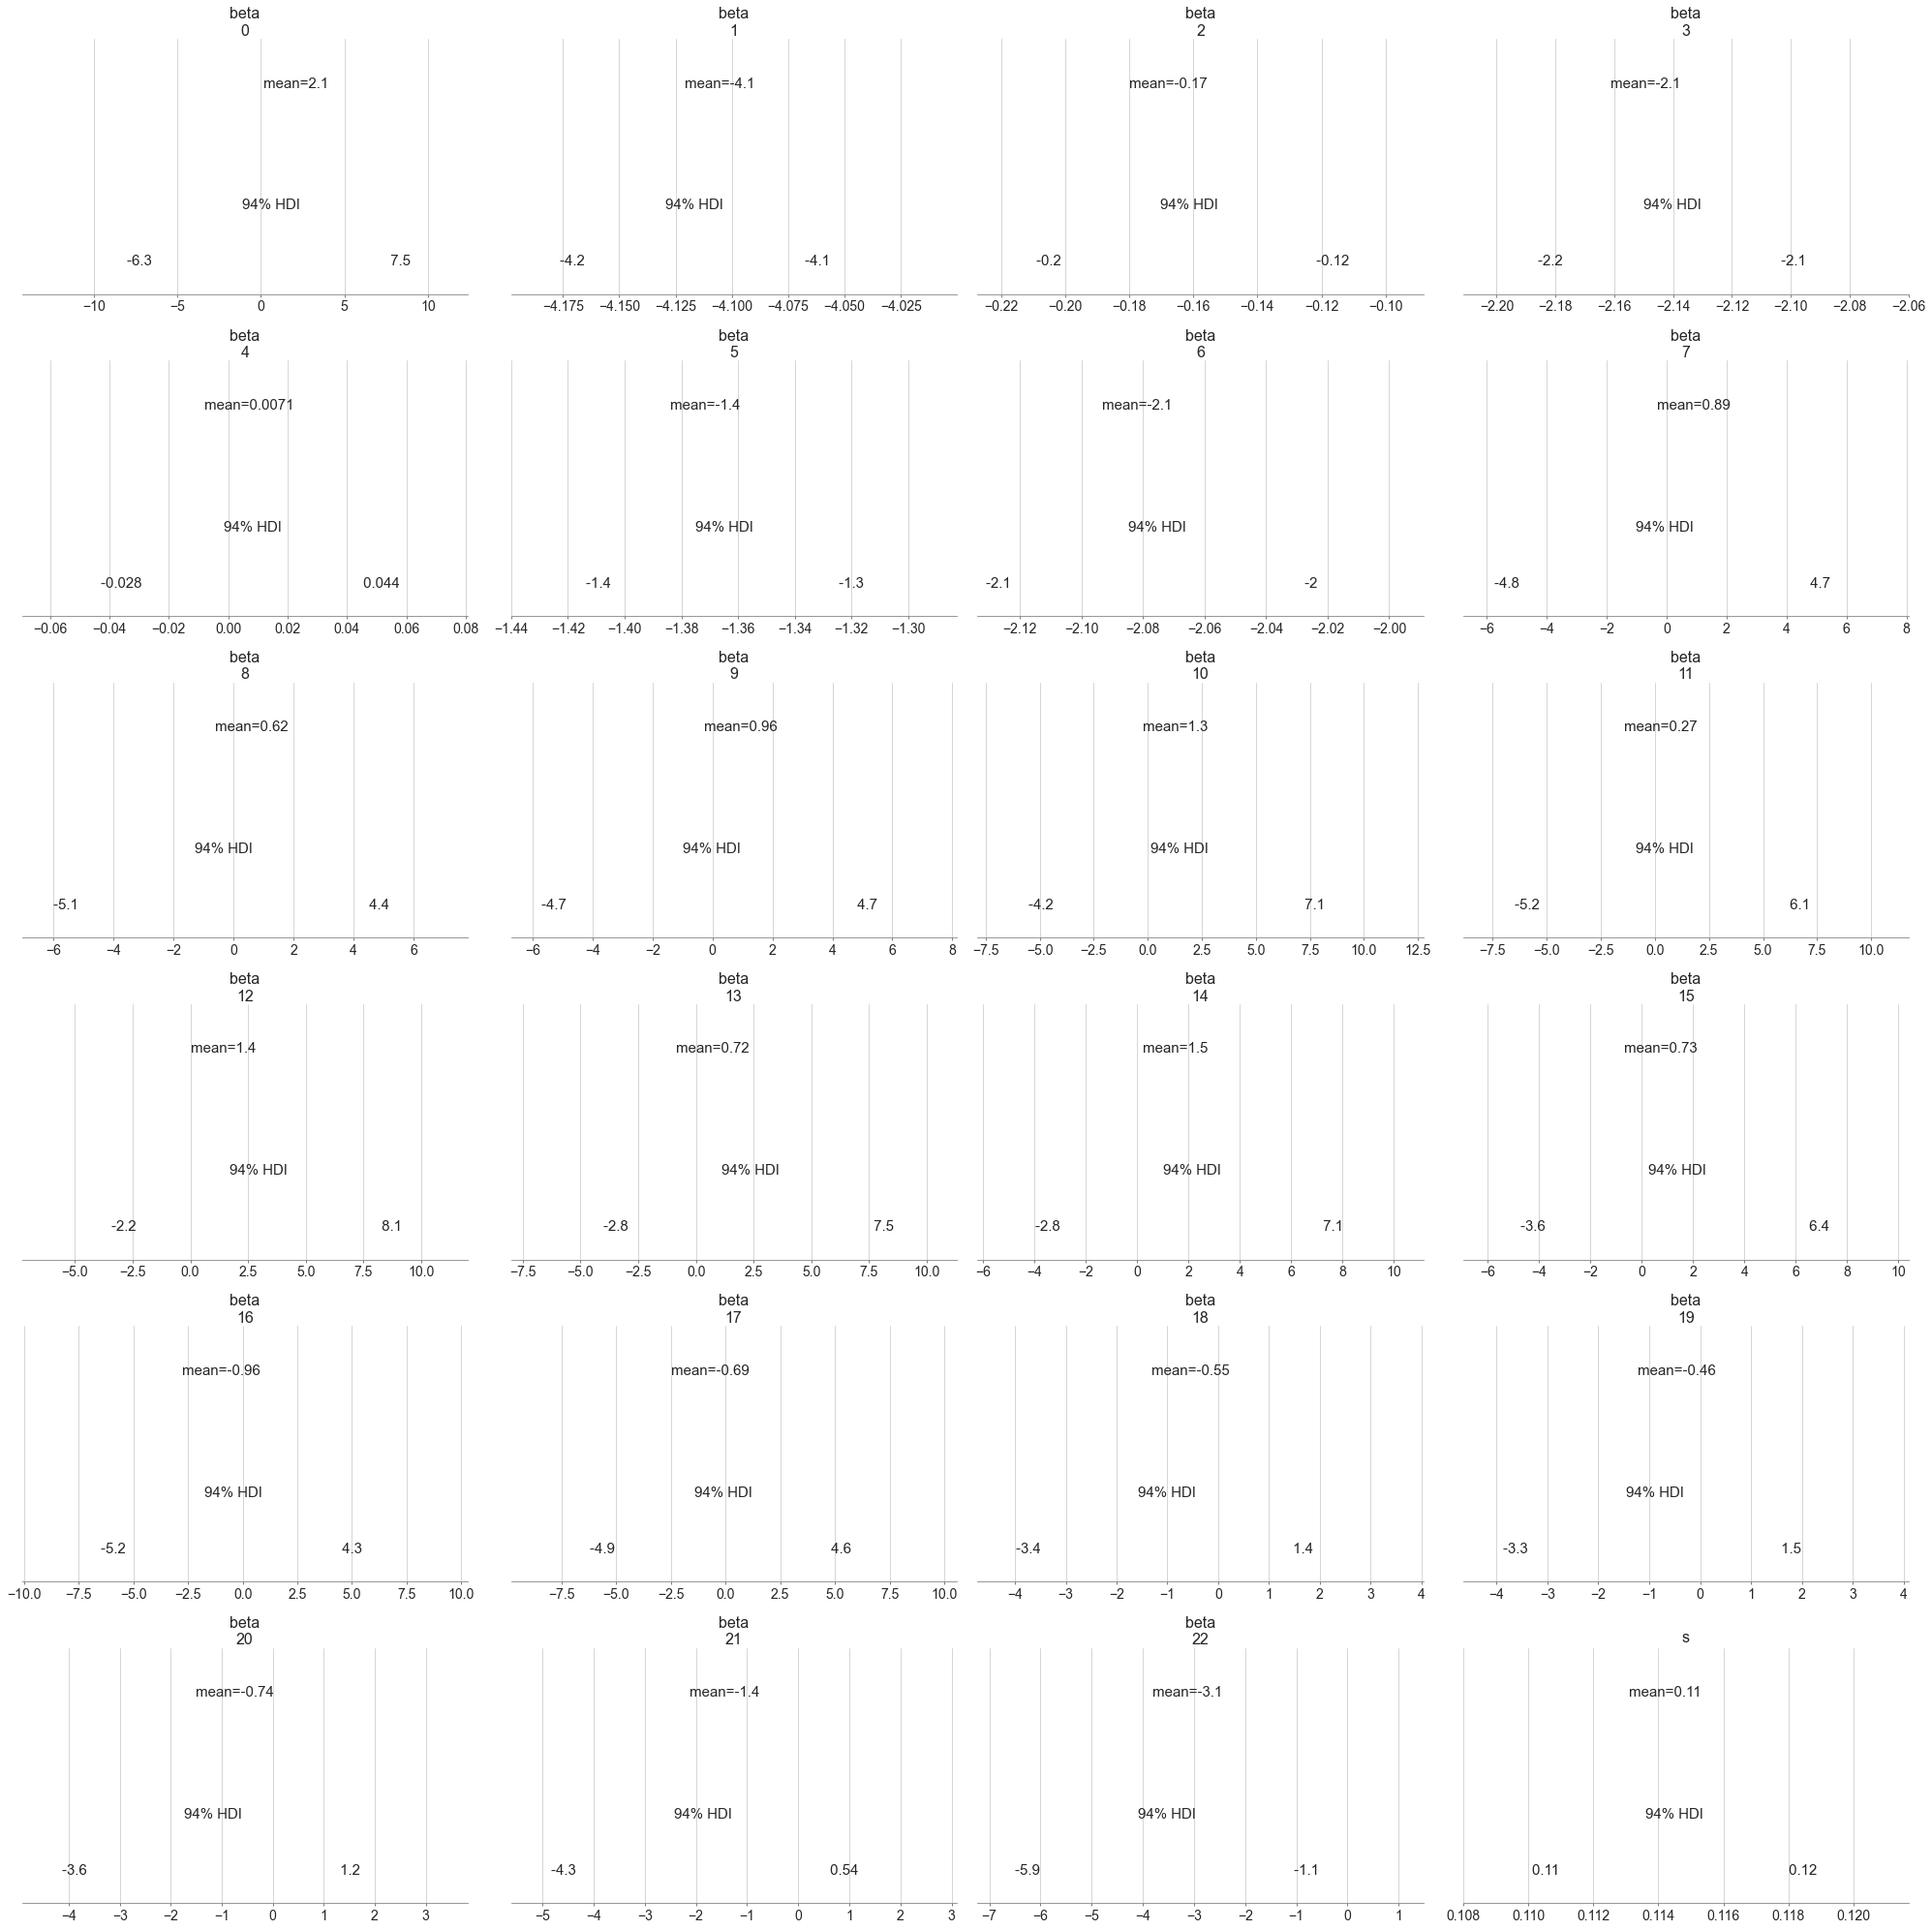

In [140]:
pm.plot_posterior(trace, lw=0, alpha=0.5);

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  UserWarning,


array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n0'}>],
       [<AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n1'}>],
       [<AxesSubplot:title={'center':'beta\n2'}>,
        <AxesSubplot:title={'center':'beta\n2'}>],
       [<AxesSubplot:title={'center':'beta\n3'}>,
        <AxesSubplot:title={'center':'beta\n3'}>],
       [<AxesSubplot:title={'center':'beta\n4'}>,
        <AxesSubplot:title={'center':'beta\n4'}>],
       [<AxesSubplot:title={'center':'beta\n5'}>,
        <AxesSubplot:title={'center':'beta\n5'}>],
       [<AxesSubplot:title={'center':'beta\n6'}>,
        <AxesSubplot:title={'center':'beta\n6'}>],
       [<AxesSubplot:title={'center':'beta\n7'}>,
        <AxesSubplot:title={'center':'beta\n7'}>],
       [<AxesSubplot:title={'center':'beta\n8'}>,
        <AxesSubplot:title={'center':'beta\n8'}>],
       [<AxesSubplot:title={'center':'beta\n9'}>,
        <AxesSubplot:title={'center':'bet

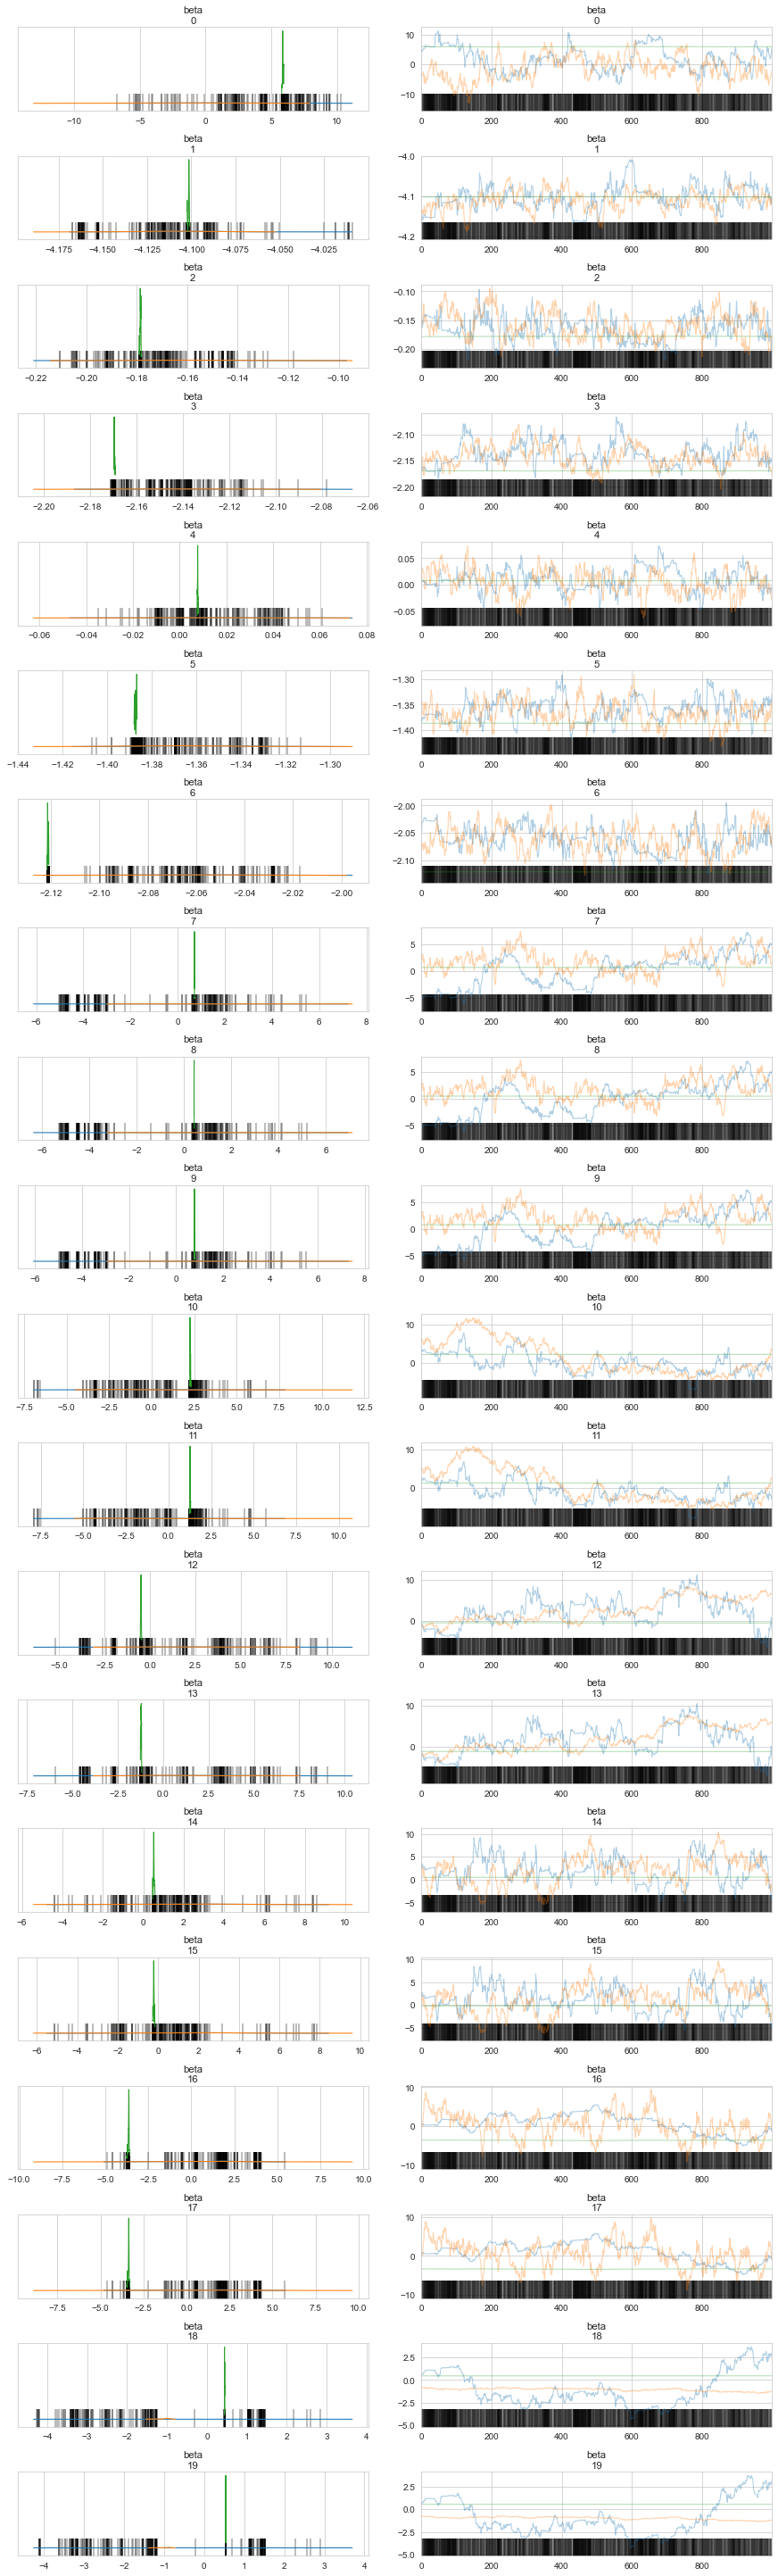

In [141]:
az.plot_trace(trace)

In [142]:
az.summary(trace)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],2.105,4.377,-6.305,7.497,1.716,1.272,7.0,7.0,8.0,34.0,1.33
beta[1],-4.106,0.023,-4.164,-4.070,0.003,0.002,72.0,72.0,55.0,112.0,1.62
beta[2],-0.168,0.020,-0.200,-0.123,0.005,0.003,19.0,19.0,23.0,158.0,1.55
beta[3],-2.149,0.023,-2.176,-2.105,0.008,0.006,8.0,8.0,8.0,149.0,1.32
beta[4],0.007,0.018,-0.028,0.044,0.002,0.003,109.0,25.0,109.0,133.0,1.69
beta[5],-1.371,0.022,-1.404,-1.326,0.007,0.005,11.0,11.0,11.0,225.0,1.22
beta[6],-2.082,0.034,-2.122,-2.029,0.016,0.012,4.0,4.0,5.0,20.0,1.77
beta[7],0.890,2.198,-4.777,4.664,0.818,0.603,7.0,7.0,8.0,12.0,1.92
beta[8],0.619,2.198,-5.051,4.396,0.818,0.604,7.0,7.0,8.0,12.0,1.82
beta[9],0.955,2.198,-4.726,4.710,0.818,0.603,7.0,7.0,8.0,12.0,1.79
